<a href="https://colab.research.google.com/github/dcorredor20/water_demand_forecasting/blob/main/Global_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/dcorredor20/water_demand_forecasting.git

  Cloning https://github.com/dcorredor20/water_demand_forecasting.git to /tmp/pip-req-build-898tphd_
  Running command git clone -q https://github.com/dcorredor20/water_demand_forecasting.git /tmp/pip-req-build-898tphd_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive
MyDrive


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from water_demand_forecasting import custom_plots
from water_demand_forecasting.wdf_model import WDF_Model
import tensorflow
import time
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Conv1D, Concatenate,BatchNormalization, ReLU, Add, ZeroPadding1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [4]:
# variables_model
VARIABLES = ["case_study", "days"]
T = 168

In [5]:
case_studies = dict()
case_studies[2] = {'train':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS2_14.txt',
                   'test':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS2_15.txt'}
case_studies[3] = {'train':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS3_14.txt',
                   'test':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS3_15.txt'}
case_studies[4] = {'train':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS4_14.txt',
                   'test':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS4_15.txt'}
case_studies[5] = {'train':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS5_14.txt',
                   'test':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS5_15.txt'}
case_studies[6] = {'train':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS6_14.txt',
                   'test':'/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS6_15.txt'}

In [6]:
for c in case_studies.keys():
  config_temp = dict()
  config_temp['case_study'] = dict()
  config_temp['days'] = dict()
  config_temp['case_study']['train'] = case_studies[c]['train']
  config_temp['case_study']['test'] = case_studies[c]['test']
  config_temp['days'] = {"train": 'gdrive/MyDrive/DataThesis/Meteo/days2014.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/days2015.csv'}
  Xtra, Ytra, Xval, Yval, Xtest, Ytest, scx, scy = WDF_Model.data_preprocessing(
      VARIABLES, config_temp, lookback=T, type_scaler = "Standard"
  )
  case_studies[c]['Xtra'] = Xtra
  case_studies[c]['Ytra'] = Ytra
  case_studies[c]['Xval'] = Xval
  case_studies[c]['Yval'] = Yval
  case_studies[c]['Xtest'] = Xtest
  case_studies[c]['Ytest'] = Ytest
  case_studies[c]['scx'] = scx
  case_studies[c]['scy'] = scy


In [7]:
Xtra = np.concatenate([case_studies[c]['Xtra'] for c in case_studies.keys()])
Xval = np.concatenate([case_studies[c]['Xval'] for c in case_studies.keys()])

In [8]:
Ytra = np.concatenate([case_studies[c]['Ytra'] for c in case_studies.keys()])
Yval = np.concatenate([case_studies[c]['Yval'] for c in case_studies.keys()])

In [10]:
# callbacks: early stopping and Model checkpoint
earlyStopping= EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, mode='auto')
mcp_save = ModelCheckpoint('model_weightsdil.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, min_delta=1e-3, mode='auto')
callbacks = [earlyStopping, mcp_save, lr_reduced]

In [11]:
dilation_rates = (2**exp for exp in range(0, 5))
filter_size_block = 2
filter_size_branch = 1
number_filters = 32
dropout_rate = 0.2
outputs = 24
loss = 'mae'
metrics = 'mse'
epochs = 500
batch_size = 32

In [12]:
i = Input(shape=(T,len(VARIABLES)), name='Input layer')

x01 = ZeroPadding1D(padding=(filter_size_block-1,0))(i)

concatenated = x01
for d in dilation_rates:
  x1 = Conv1D(filters=number_filters, kernel_size=(filter_size_branch))(concatenated)

  x2 = Conv1D(number_filters, kernel_size=(filter_size_block), padding='causal', dilation_rate=d)(concatenated)
  x2 = BatchNormalization()(x2)
  x2 = ReLU()(x2)
  x2 = Dropout(rate=dropout_rate, seed=1234)(x2)
  concatenated = Add()([x2, x1])
   
x = Flatten()(concatenated)

x = Dense(units=outputs, activation='linear', name='Output')(x)

model = Model(i, x)
print(model.summary())

# compile the model
optimizer = Adam(learning_rate = 0.0005)
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input layer (InputLayer)        [(None, 168, 2)]     0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 169, 2)       0           Input layer[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 169, 32)      160         zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 169, 32)      128         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
start = time.time()
r = model.fit(Xtra, Ytra, verbose = 1, validation_data=(Xval, Yval), epochs=epochs, callbacks=callbacks, batch_size=batch_size)
end = time.time()
print('Total training time: ', end-start)

Epoch 1/500
1005/1005 [==============================] - 45s 11ms/step - loss: 0.4383 - mse: 0.4408 - val_loss: 0.1514 - val_mse: 0.0428
Epoch 2/500
1005/1005 [==============================] - 11s 11ms/step - loss: 0.1693 - mse: 0.0522 - val_loss: 0.1371 - val_mse: 0.0375
Epoch 3/500
1005/1005 [==============================] - 10s 10ms/step - loss: 0.1434 - mse: 0.0400 - val_loss: 0.1298 - val_mse: 0.0334
Epoch 4/500
1005/1005 [==============================] - 10s 10ms/step - loss: 0.1339 - mse: 0.0361 - val_loss: 0.1204 - val_mse: 0.0312
Epoch 5/500
1005/1005 [==============================] - 10s 10ms/step - loss: 0.1290 - mse: 0.0343 - val_loss: 0.1225 - val_mse: 0.0312
Epoch 6/500
1005/1005 [==============================] - 10s 10ms/step - loss: 0.1257 - mse: 0.0331 - val_loss: 0.1176 - val_mse: 0.0297
Epoch 7/500
1005/1005 [==============================] - 10s 10ms/step - loss: 0.1227 - mse: 0.0319 - val_loss: 0.1171 - val_mse: 0.0300
Epoch 8/500
1005/1005 [==================

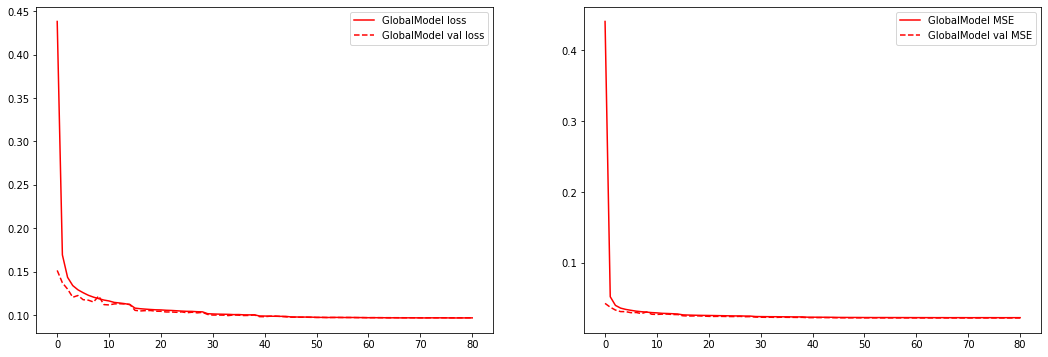

In [14]:
custom_plots.loss_plot(r, 'GlobalModel', color = 'r')

In [15]:
model.load_weights('model_weightsdil.hdf5')

In [16]:
def print_metrics(y,ypred,dataset, scy):
  y = scy.inverse_transform(y)
  ypred = scy.inverse_transform(ypred)
  print(f'{dataset}\t\tRMSE:{mean_squared_error(y,ypred)**0.5:.3f}\tMAE:{mean_absolute_error(y,ypred):.3f}\tR2:{r2_score(y,ypred):.3f}')

In [17]:
for c in case_studies.keys():
  print(f'Test for CS{c}')
  print_metrics(case_studies[c]['Ytest'].reshape(-1,1),model.predict(case_studies[c]['Xtest']).reshape(-1,1),'Test',case_studies[c]['scy'])

Test for CS2
Test		RMSE:41.082	MAE:29.490	R2:0.954
Test for CS3
Test		RMSE:4.615	MAE:3.151	R2:0.969
Test for CS4
Test		RMSE:1.229	MAE:0.794	R2:0.979
Test for CS5
Test		RMSE:2.504	MAE:1.627	R2:0.951
Test for CS6
Test		RMSE:6.404	MAE:4.293	R2:0.980


In [18]:
for c in case_studies.keys():
  for y in [1,2]:
    mode = 'val' if y == 1 else 'test'
    Y_hat = model.predict(case_studies[c][f'X{mode}'])
    Y_test = case_studies[c]['scy'].inverse_transform(case_studies[c][f'Y{mode}'])
    Yhat = case_studies[c]['scy'].inverse_transform(Y_hat)
    dat1y2 = pd.DataFrame(Y_test)
    dat2y2 = pd.DataFrame(Yhat)
    e = 100*np.sum(np.abs((dat1y2 - dat2y2)/np.mean(dat1y2, axis = 0)), axis = 0)/len(dat1y2)
    print(f'MAE CS{c} Year {y} = {e.mean()}')
  print('-'*10)

MAE CS2 Year 1 = 2.1898838570199994
MAE CS2 Year 2 = 3.0492126490379428
----------
MAE CS3 Year 1 = 2.8028393034865453
MAE CS3 Year 2 = 3.2840456840994374
----------
MAE CS4 Year 1 = 2.989449327124058
MAE CS4 Year 2 = 3.215735261684264
----------
MAE CS5 Year 1 = 2.5612284820465874
MAE CS5 Year 2 = 2.866633070899496
----------
MAE CS6 Year 1 = 2.161666396989536
MAE CS6 Year 2 = 2.419545151353662
----------
